In [1]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import math
from skimage import io
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage import measure
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
EPOCHS = 30
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

import tensorflow.compat.v1 as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
OBJ_CLASSES = ["card", "name", "set_symbol"]
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Num GPUs Available:  1


In [17]:
def get_file_paths(dir_path):
    file_paths = []
    for root, directories, files in os.walk(dir_path):
        for file in files:
            if not file.startswith("."):
                file_path = os.path.join(root, file)
                file_path = os.path.abspath(file_path)
                file_paths.append(file_path)
    return file_paths



############################################################
#  Configurations
############################################################


class MTGCardTrainConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mtg_card"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = len(OBJ_CLASSES) + 1  # Background + mtg_card classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.92

    USE_MINI_MASK = False
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    BACKBONE = "resnet101"
    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # use small validation steps since the epoch is small
    # VALIDATION_STEPS = 5


class MTGCardInferConfig(MTGCardTrainConfig):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.7


############################################################
#  Dataset
############################################################

class MTGCardDataset(utils.Dataset):

    def load_card(self, dataset_dir, subset):
        """Load a subset of the MTGCard dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes.
        for i, obj_class in enumerate(OBJ_CLASSES):
            self.add_class("mtg_card", i+1, obj_class)

        json_path = os.path.join(dataset_dir, "annotations.json")
        with open(json_path) as f:
            annotations = json.load(f)
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        files = get_file_paths(dataset_dir)
        # Add images
        for image_path in files:
            fname = os.path.split(image_path)[-1]
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # I am using a constant shape for now
            height, width = (640,640)
            # Keep only labels we want to classify
            polygons = {k:v for k,v in annotations[fname]['bbox'].items() if k in OBJ_CLASSES}

            self.add_image(
                "mtg_card",
                image_id=fname,  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "mtg_card":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "mtg_card":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = []
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
        for i, label in enumerate(image_info["polygons"]):
            class_id = OBJ_CLASSES.index(label)+1
            p = image_info["polygons"][label]
            x = [x[0] for x in p]
            y = [y[1] for y in p]
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(y, x)
            mask[rr, cc, i] = 1
            class_ids.append(class_id)

        return mask.astype(np.bool), np.array(class_ids, dtype=np.int32)

def train(model, dataset_dir, config):
    """Train the model."""
    # Training dataset.
    dataset_train = MTGCardDataset()
    dataset_train.load_card(dataset_dir, "train")
    dataset_train.prepare()
    # Validation dataset
    dataset_val = MTGCardDataset()
    dataset_val.load_card(dataset_dir, "val")
    dataset_val.prepare()
    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=EPOCHS,
                layers='heads')

def bitmask_to_bounding_box(bitmask):
    # Find the non-zero elements in the bitmask
    non_zero_elements = cv2.findNonZero(bitmask)

    # Use the minAreaRect function to find the bounding box of the rotated rectangle
    rect = cv2.minAreaRect(non_zero_elements)

    # Extract the bounding box points from the rect object
    bounding_box = cv2.boxPoints(rect)

    # Convert the bounding box points to integer values
    bounding_box = np.int0(bounding_box)

    return bounding_box

def draw_boxes(image, masks, class_ids, scores):
    # original image of shape (height, width, channels)
    # list of binary masks of shape (height, width)
    # list of class ids, one for each mask

    # Visualize the bounding boxes and class labels on top of the original image
    fig, ax = plt.subplots()

    # TODO: merge overlapping guesses first
    best_guess = {k:(-1*float('Inf'), None) for k in set(class_ids)}
    for i, class_id in enumerate(class_ids):
        top = best_guess[class_id]
        if top[0] < scores[i]:
            best_guess[class_id] = (scores[i], i)

    for class_id, (score, i) in best_guess.items():
        mask = masks[:, :, i]
        # class_id = class_ids[i]
        coords = bitmask_to_bounding_box(mask.astype(np.uint8))
        # Draw the bounding box on the image
        cv2.polylines(image, [coords], True, (0, 0, 255), 2)
    for class_id, (score, i) in best_guess.items():
        mask = masks[:, :, i]
        # class_id = class_ids[i]
        label = OBJ_CLASSES[class_id-1]
        coords = bitmask_to_bounding_box(mask.astype(np.uint8))
        x, y, w, h = cv2.boundingRect(coords)
        center_x, center_y = x + w // 2, y + h // 2
        # Convert the coordinates to a numpy array
        coords = np.array(coords, dtype=np.int32)
        # Add black border
        cv2.putText(image, label, (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3, cv2.LINE_AA)
        # Put the label text on the image
        cv2.putText(image, label, (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    # Display the image
    ax.imshow(image)
    # Show the image
    plt.show()


def crop_image(image, masks, class_ids, scores):
    fig, ax = plt.subplots()
    # TODO: merge overlapping guesses first
    best_guess = {k:(-1*float('Inf'), None) for k in set(class_ids)}
    for i, class_id in enumerate(class_ids):
        top = best_guess[class_id]
        if top[0] < scores[i]:
            best_guess[class_id] = (scores[i], i)
    # Identify corner of larger bounding box where inner bounding box is located
    large_bounding_box = bitmask_to_bounding_box(masks[:, :, best_guess[OBJ_CLASSES.index('card')][1]].astype(np.uint8))
    # Sortby distance to origin
    large_bounding_box = sorted(large_bounding_box, key=lambda x:np.sqrt(x[0]**2+x[1]**2))
    x1, y1, x2, y2 = large_bounding_box[0], large_bounding_box[-1]  # coordinates of larger bounding box
    # Calculate center of larger bounding box
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    inner_bounding_box = bitmask_to_bounding_box(masks[:, :, best_guess[OBJ_CLASSES.index('name')][1]].astype(np.uint8))
    # Sortby distance to origin
    inner_bounding_box = sorted(inner_bounding_box, key=lambda x:np.sqrt((x[0]-center_x)**2+(x[1]-center_y)**2))
    inner_x1, inner_y1, inner_x2, inner_y2 = inner_bounding_box[-1], inner_bounding_box[0]  # coordinates of inner bounding box
    corner_x, corner_y = inner_x1, inner_y1

    # Calculate rotation angle
    angle = math.atan2(corner_y - center_y, corner_x - center_x)

    # Crop image
    cropped_image = image[y1:y2, x1:x2]

    # Rotate image
    (height, width) = cropped_image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(cropped_image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    # Display the image
    ax.imshow(rotated_image)
    # Show the image
    plt.show()

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

def detect_and_color_splash(model, image_path):
    # Run model detection and generate the color splash effect
    print("Running on {}".format(image_path))
    # Read image
    image = skimage.io.imread(image_path)
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    draw_boxes(image, r['masks'], r['class_ids'], r['scores'])
    # # Color splash
    # print(r.keys())
    # splash = color_splash(image, r['masks'])
    # # Save output
    # file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
    # fname = os.path.split(image_path)[0]
    
    # skimage.io.imsave(os.path.join(fname, '..', file_name), splash)
    # print("Saved to ", file_name)

Initalize paths and configs

In [3]:
data_dir = os.path.join(ROOT_DIR, "assets", "augmented_data")

logs_dir = os.path.join(data_dir, "logs")

test_train_file = '00d594df-c51b-4936-9af1-536dab1792ae_02a16hbe-550x550_jpeg_0.jpg'

config = MTGCardTrainConfig()


# dataset_train = MTGCardDataset()
# dataset_train.load_card(data_dir, "train")
# dataset_train.prepare()
# img = dataset_train.load_mask_classes(test_train_file)


In [ ]:
# io.imshow(img)


Use the Next block to train model, skip if you only want to run inference on the latest model

In [ ]:

from keras.backend import manual_variable_initialization 
manual_variable_initialization(False)

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=logs_dir)

# weights_path = model.get_imagenet_weights() 
weights_path = model.find_last()
print(weights_path)

tf.keras.Model.load_weights(model.keras_model, weights_path, by_name=True, skip_mismatch=['output_layer'])

train(model, data_dir, config)

Use this block to test the model

In [16]:
config = MTGCardInferConfig()


inference_model = model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=logs_dir)
weights_path = model.find_last()
print(weights_path)

tf.keras.Model.load_weights(model.keras_model, weights_path, by_name=True)
# model.load_weights(weights_path, by_name=True)

dataset_dir = os.path.join(data_dir, 'test')
files = get_file_paths(dataset_dir)



d:\aktwelve_mask_rcnn\assets\augmented_data\logs\mtg_card20221230T2338\mask_rcnn_mtg_card_0194.h5


In [ ]:
image = skimage.io.imread(os.path.join(data_dir, 'train', test_train_file))
# Detect objects
r = model.detect([image], verbose=1)[0]

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\ade8f32c-d188-4a36-98a4-584b6ef95902_41477_2019_374_Figa_HTML_jpeg_0.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


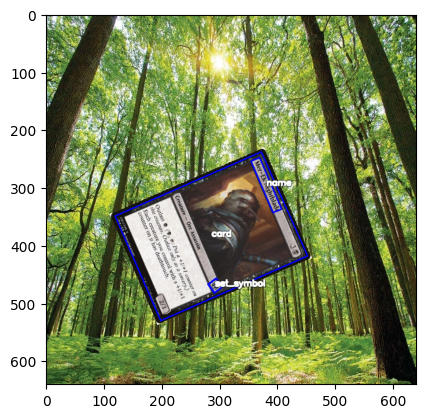

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\402bbbd8-b490-4a5c-9083-f0103c8712cb_Swamp-5-3-_960px_jpeg_1.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


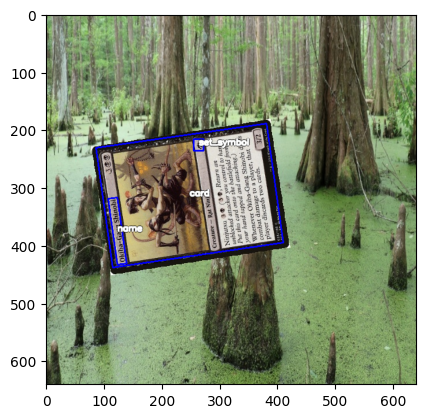

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\9efcf24c-ad57-4320-9b85-c838f5ed659b_maldives-02-ISLANDSWB22-6a20de5bab364426b25293af566d8161_jpeg_1.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


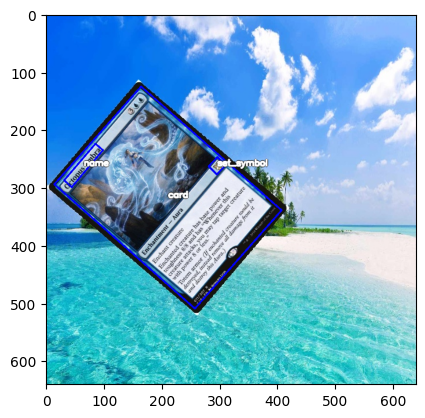

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\903e30f3-580e-4a14-989b-ae0632363407_grand-teton-rocky-mountains-USMNTNS0720-52499caea565471a8571acdfc3dfd9fe_jpeg_3.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


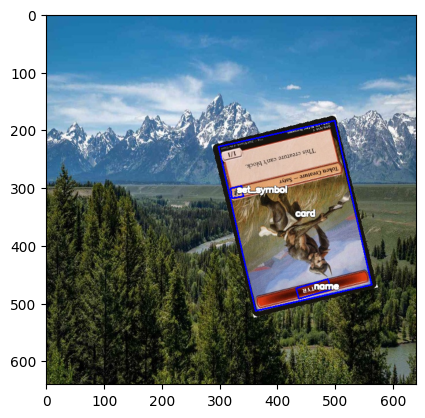

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\13a0913d-776b-4ef8-adef-8861349df2b5_anime-beautiful-sky-synthetic-background_6229374_jpg_3.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


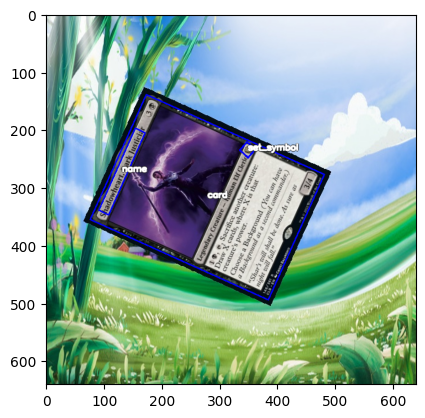

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\d0a8508d-25a7-4fb2-8aa3-349275f80c42_wave-pattern-desert-landscape--oman-886145780-5c45542046e0fb00012ebabf_jpeg_0.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


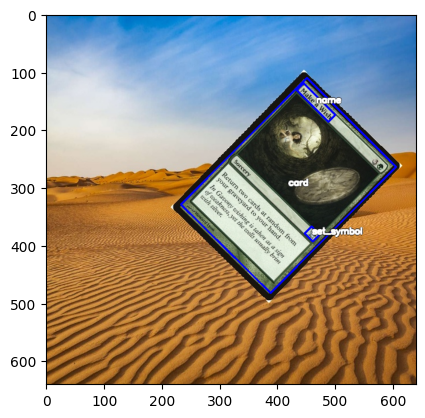

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\29d852c4-bd53-4a3b-b1e2-896917cbc27f_wave-pattern-desert-landscape--oman-886145780-5c45542046e0fb00012ebabf_jpeg_3.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


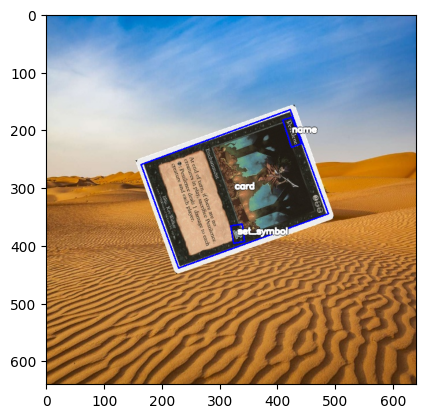

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\e30980d4-b12e-4504-b257-c920b073fd91_table_bg_jpeg_3.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


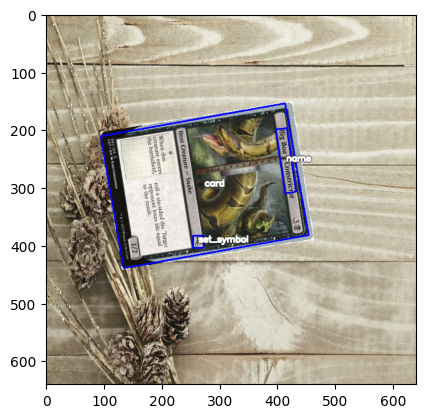

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\e34de3df-3236-4281-a043-7583c76d89cc_02a16hbe-550x550_jpeg_0.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


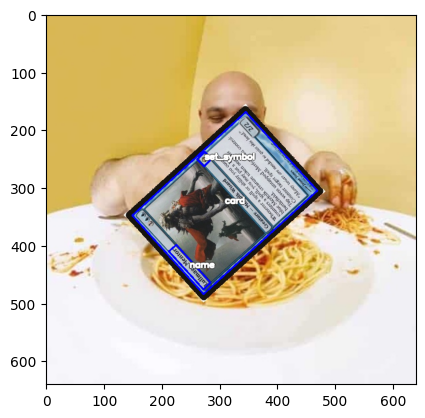

Running on d:\aktwelve_mask_rcnn\assets\augmented_data\test\cbb8edd0-4573-4b52-a3ea-83ed19dbf58d_abstract-wallpaper-preview_jpeg_3.jpg
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


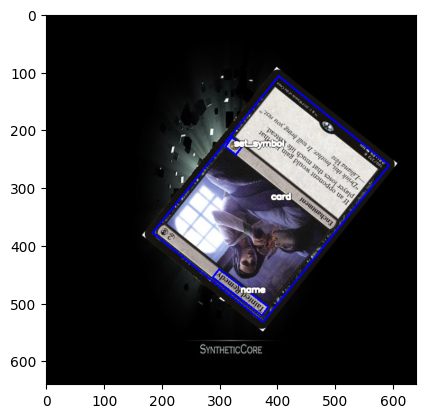

In [19]:
random.shuffle(files)
for i in range(10):
    detect_and_color_splash(model, files[i])